In [204]:
import numpy as np
import operator
import math
import datetime
from dateutil import relativedelta

In [181]:
def importDebitsMensuels(path) :
    res = {}
    file = open(path,"r")
    line = file.readline()
    while line :
        if len(line.strip()) > 0 :
            if line.strip()[0] != "#" :
                data = line.strip().split(",")
                list_debit = []
                for i in data[1:] :
                    list_debit.append(float(i))
                res.update({data[0]:{"debit_mensuels":list_debit,
                                     "debit_max":max(list_debit),
                                     "debit_min":min(list_debit)}})
        line = file.readline()
    file.close()
    return res

In [182]:
def importDebitAnnuels(path, formatt) :
    res = {}
    file = open(path,"r")
    line = file.readline()
    while line :
        if len(line.strip()) > 0 :
            if line.strip()[0] != "#" :
                data = line.strip().split(";")
                datee = datetime.datetime.strptime(data[0], formatt)
                res.update({datee:{"debit_max":float(data[1])}})
        line = file.readline()
    file.close()
    return res

In [183]:
def plot_stationnarite(data, name) :

    import matplotlib.pyplot as plt

    debit_max = -9999.999

    fig = plt.figure()
    
    for cle, donne in data.items() :
        plt.plot(cle, donne["debit_max"], marker="o", color="red")
        if debit_max < donne["debit_max"] :
            debit_max = donne["debit_max"]
    
    plt.grid()
    plt.xlabel("Années")
    plt.ylabel("Débit [$m^3\cdot s^{-1}$]")
    plt.ylim(0,round(debit_max, -2))
    plt.title("Stationnarité ({:s}/{:s})".format(str(list(data.keys())[0]), str(list(data.keys())[-1])))
    fig.autofmt_xdate(rotation=45)
    plt.savefig(name+"_stationnarite.pgf")

In [184]:
def plot_homogeneite(data, name) :

    import matplotlib.pyplot as plt

    mois = ['Janvier','Fevrier','Mars','Avril','Mai','Juin','Juillet','Aout','Septembre','Octobre','Novembre','Decembre']
    mois = np.array(mois)

    fig = plt.figure()

    for annee in data.keys() :
        debit = []
        for i in data[annee]['debit_mensuels'] :
            debit.append(i)
        debit = np.array(debit)
        plt.plot(mois,debit)

    plt.grid()
    plt.xlabel("Mois")
    plt.ylabel("Débit [$m^3\cdot s^{-1}$]")
    plt.title("Homogénéité ({:s}-{:s})".format(list(data.keys())[0], list(data.keys())[-1]))
    fig.autofmt_xdate(rotation=45)
    plt.savefig(name+"_homogeneite.pgf")

In [216]:
def calcul_TempsRetour(data_dict, formule=[], traitement = "annuels") :

    data_tried = dict(sorted(data_dict.items(), key=lambda x: x[1]["debit_max"], reverse=True))
    
    annee = len(data_tried)
    if traitement in ["tronquees","tronquee"] :
        datee = list(data_tried.keys())
        datee_min = min(datee)
        datee_max = max(datee)
        diff = relativedelta.relativedelta(datee_max, datee_min)
        annee = diff.years+1

    rang = 1
    for key, data in data_tried.items() :
        data.update({"rang":rang})
        data.update({"temps_retour_Hazen":tempsRetour("Hazen", rang, annee)})
        for form in formule :
            if form != "Hazen" or form != "hazen" :
                name = "temps_retour_" + form
                data.update({name:tempsRetour(form, rang, annee)})
        rang += 1
    print(rang-1, annee)
    return data_tried
    

def tempsRetour(name, rang, annee) :

    if name.lower() == "hazen" :
        tRetour = annee / (rang - 0.5)
    elif name.lower() == "weibull" :
        tRetour = (annee + 1) / rang
    elif name.lower() == "mediane" :
        tRetour = (annee + 0.365) / (rang - 0.3175)
    elif name.lower() == "hosking" :
        tRetour = (annee) / (rang - 0.35)
    elif name.lower() == "blom" :
        tRetour = (annee + 0.25) / (rang - 0.375)
    elif name.lower() == "cunnane" :
        tRetour = (annee + 0.20) / (rang - 0.40)
    elif name.lower() == "gringorten" :
        tRetour = (annee + 0.12) / (rang - 0.44)
    else :
        tRetour = np.nan
    return tRetour

In [186]:
def plot_tempsRetour(data, name) :
    import matplotlib.pyplot as plt

    fig = plt.figure()

    debit_max = -9999.999

    Tretour = {}
    Tretour.update({"Hazen":[]})
    Tretour.update({"Weibull":[]})
    Tretour.update({"Mediane":[]})
    Tretour.update({"Hosking":[]})
    Tretour.update({"Blom":[]})
    Tretour.update({"Cunnane":[]})
    Tretour.update({"Gringorten":[]})
    
    for donne in data.values() :
        Tretour["Hazen"].append([donne["temps_retour_Hazen"],donne["debit_max"]])
        if debit_max < donne["debit_max"] :
            debit_max = donne["debit_max"]
        if "temps_retour_Weibull" in list(donne.keys()) :
            Tretour["Weibull"].append([donne["temps_retour_Weibull"],donne["debit_max"]])
        if "temps_retour_Mediane" in list(donne.keys()) :
            Tretour["Mediane"].append([donne["temps_retour_Mediane"],donne["debit_max"]])
        if "temps_retour_Hosking" in list(donne.keys()) :
            Tretour["Hosking"].append([donne["temps_retour_Hosking"],donne["debit_max"]])
        if "temps_retour_Blom" in list(donne.keys()) :
            Tretour["Blom"].append([donne["temps_retour_Blom"],donne["debit_max"]])
        if "temps_retour_Cunnane" in list(donne.keys()) :
            Tretour["Cunnane"].append([donne["temps_retour_Cunnane"],donne["debit_max"]])
        if "temps_retour_Gringorten" in list(donne.keys()) :
            Tretour["Gringorten"].append([donne["temps_retour_Gringorten"],donne["debit_max"]])
    
    for key, data in Tretour.items() :
        if len(data) > 0 :
            arrayyy = np.array(data)
            plt.plot(arrayyy[:,0], arrayyy[:,1], 'o-', label=key)

    plt.grid()
    plt.xlabel("Temps de retour [année]")
    plt.ylim(0,round(debit_max, -2))
    plt.ylabel("Débit [$m^3\cdot s^{-1}$]")
    plt.title("Temps de retour calculé")
    plt.legend(loc=4)
    plt.savefig(name+"_tempsRetour.pgf")


In [210]:
def exportData(data, path) :
    file = open(path, "w")
    file.write("#Année&Rang&Débit&TempsRetour\n")
    for key, donne in data.items() :
        file.write("{:s}&{:d}&{:0.3f}&{:0.2f}\n".format(str(key),donne["rang"],donne["debit_max"],donne["temps_retour_Hazen"]))
    file.close()

In [188]:
def calculDebitGumbel(a, b, Tretour) :
    fre = 1 - (1/Tretour)
    u = -np.log(-np.log(fre))
    q = a + b * u
    return fre, u, q

def calcul_gumbel(data) :
    debit_maxi = []
    for donne in data.values() :
        debit_maxi.append(donne["debit_max"])
    debit_maxi = np.array(debit_maxi)

    moy = np.mean(debit_maxi)
    std = np.std(debit_maxi)
    b = np.sqrt(6)/np.pi * std
    a = moy - 0.5772 * b

    paramGumbel = {}
    paramGumbel.update({"moyenne":moy})
    paramGumbel.update({"ecart-type":std})
    paramGumbel.update({"a":a})
    paramGumbel.update({"b":b})

    for donne in data.values() :
        tRetour = donne["temps_retour_Hazen"]
        fre, u, q = calculDebitGumbel(a, b, tRetour)
        donne.update({"F_Q":fre})
        donne.update({"U":u})
        donne.update({"Q_Gumbel":q})
    
    return data, paramGumbel

In [189]:
def plot_Gumbel(data, name, data_extrapolation = {}) :
    import matplotlib.pyplot as plt

    fig = plt.figure()

    debit_u = []
    debit_gumbel_u = []
    debit_T = []
    debit_gumbel_T = []

    for donne in data.values() :
        debit_u.append([donne["U"],donne["debit_max"]])
        debit_gumbel_u.append([donne["U"],donne["Q_Gumbel"]])
        debit_T.append([donne["temps_retour_Hazen"],donne["debit_max"]])
        debit_gumbel_T.append([donne["temps_retour_Hazen"],donne["Q_Gumbel"]])
    
    debit_u = np.array(debit_u)
    debit_gumbel_u = np.array(debit_gumbel_u)
    debit_T = np.array(debit_T)
    debit_gumbel_T = np.array(debit_gumbel_T)

    plt.plot(debit_u[:,0], debit_u[:,1], 'o-', label="Débit observé")
    plt.plot(debit_gumbel_u[:,0], debit_gumbel_u[:,1], 'o-', label="Débit Gumbel")
    if len(data_extrapolation) > 0 :
        debit_u = []
        for cle, donne in data_extrapolation.items() :
            debit_u.append([donne["u"],donne["q"]])
        debit_u = np.array(debit_u)
        plt.plot(debit_u[:,0], debit_u[:,1], 'o-', label="Débit extrapolé")
    

    plt.grid()
    plt.xlabel("Variable réduite $U$ de la loi de Gumbel")
    #plt.ylim(0,round(debit_max, -2)+100)
    plt.ylabel("Débit [$m^3\cdot s^{-1}$]")
    plt.title("Ajustement par la loi de Gumbel simplifiée")
    plt.legend(loc=4)
    plt.savefig(name+"_U.pgf")

    fig = plt.figure()
    plt.plot(debit_T[:,0], debit_T[:,1], 'o-', label="Débit observé")
    plt.plot(debit_gumbel_T[:,0], debit_gumbel_T[:,1], 'o-', label="Débit Gumbel")
    if len(data_extrapolation) > 0 :
        debit_T = []
        for cle, donne in data_extrapolation.items() :
            debit_T.append([int(cle),donne["q"]])
        debit_T = np.array(debit_T)
        plt.plot(debit_T[:,0], debit_T[:,1], 'o-', label="Débit extrapolé")

    plt.grid()
    plt.xlabel("Temps de retour [année]")
    #plt.ylim(0,round(debit_max, -2)+100)
    plt.ylabel("Débit [$m^3\cdot s^{-1}$]")
    plt.xscale("log")
    plt.title("Ajustement par la loi de Gumbel simplifiée")
    plt.legend(loc=4)
    plt.savefig(name+"_T.pgf")

In [190]:
def exportData2(data, path) :
    file = open(path, "w")
    file.write("#Année & Rang & Débit & TempsRetour & F(Q) & U & Q \n")
    for key, donne in data.items() :
        file.write("{:s} & {:d} & {:0.2f} & {:0.2f} & {:0.2f} & {:0.2f} & {:0.2f}\n".format(key,donne["rang"],donne["debit_max"],donne["temps_retour_Hazen"],donne["F_Q"],donne["U"],donne["temps_retour_Hazen"],))
    file.close()

In [191]:
def extrapolation_gumbel(liste_temps, paramGumbel) :
    res = {}
    for temps in liste_temps :
        a = paramGumbel['a']
        b = paramGumbel['b']
        fre, u, q = calculDebitGumbel(a, b, temps)
        res.update({str(temps):{'fre':fre,'u':u,'q':q}})
    return res


In [192]:
def exportData3(data, path) :
    file = open(path, "w")
    file.write("#TempsRetour & F(Q) & U & Q \n")
    for key, donne in data.items() :
        file.write("{:s} & {:0.2f} & {:0.2f} & {:0.2f}\n".format(key,donne["fre"],donne["u"],donne["q"],))
    file.close()

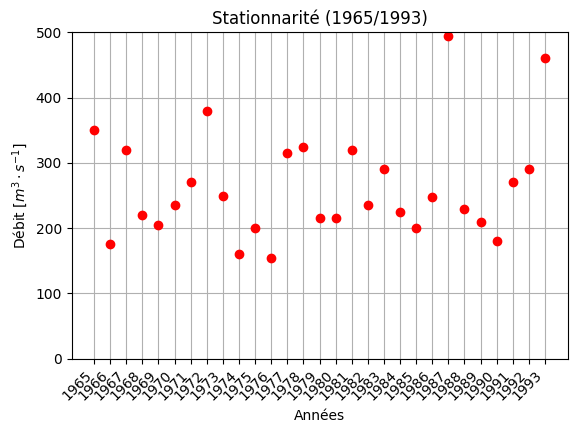

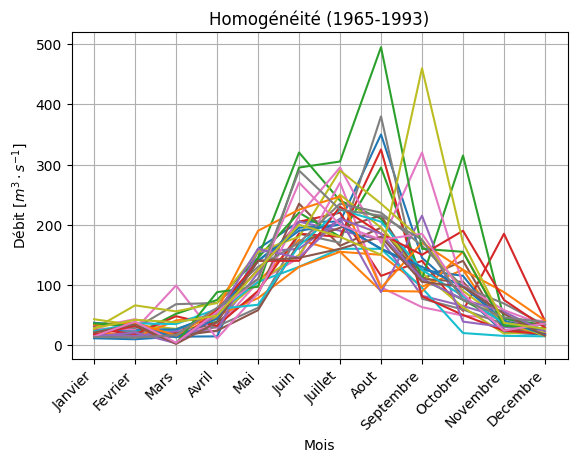

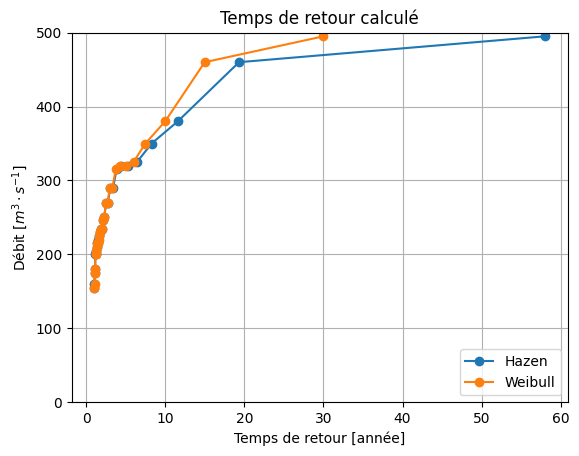

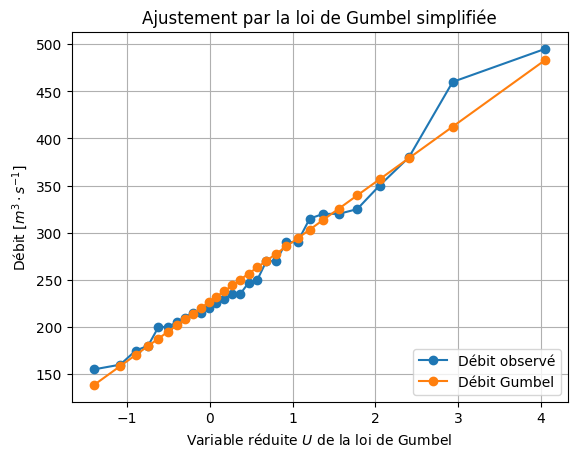

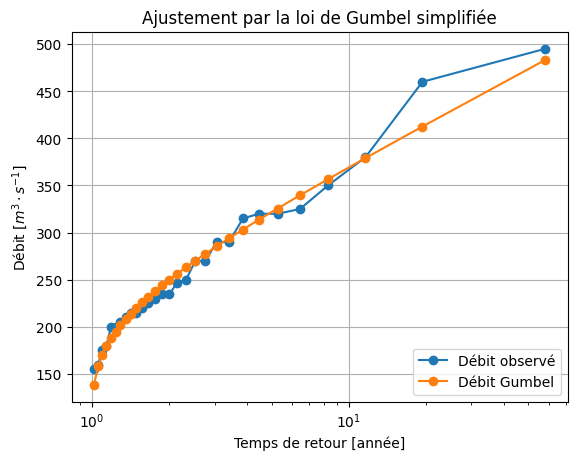

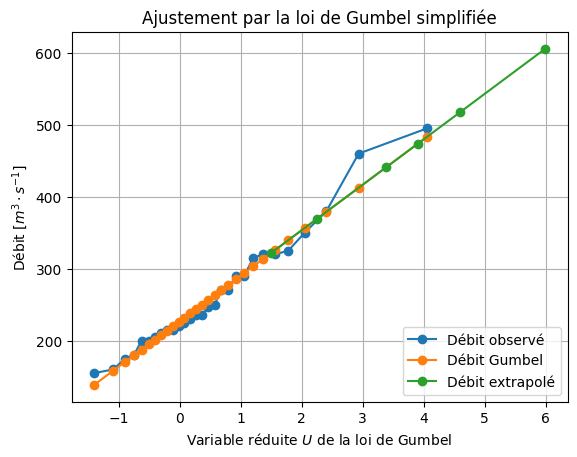

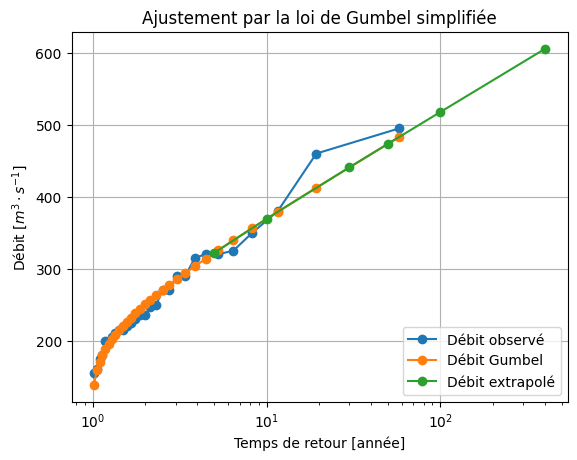

In [193]:
### SERIES ANNUELLES

reper = "seriesAnnuelles/"
serieAnnuelles = importDebitsMensuels(reper+"data_extrapolation.txt")
plot_stationnarite(serieAnnuelles, reper+"serieAnnuelles")
plot_homogeneite(serieAnnuelles, reper+"serieAnnuelles")

serieAnnuelles = calcul_TempsRetour(serieAnnuelles, ["Weibull"])
plot_tempsRetour(serieAnnuelles, reper+"serieAnnuelles")
exportData(serieAnnuelles, reper+"exportTempsRetour.txt")

serieAnnuelles, param = calcul_gumbel(serieAnnuelles)
plot_Gumbel(serieAnnuelles, reper+"serieAnnuelles_loiGumbel")
exportData2(serieAnnuelles, reper+"exportGumbel.txt")

temps = [5, 10, 30, 50, 100, 400]
data_temps = extrapolation_gumbel(temps, param)
exportData3(data_temps, reper+"export_extrapolationGumbel.txt")
plot_Gumbel(serieAnnuelles, reper+"serieAnnuelles_loiGumbel_extrapole", data_temps)

110 21


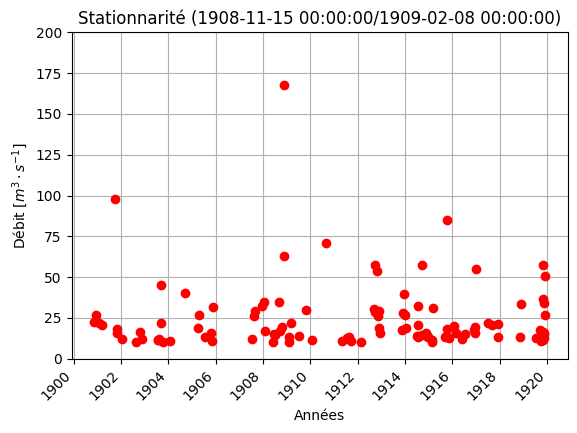

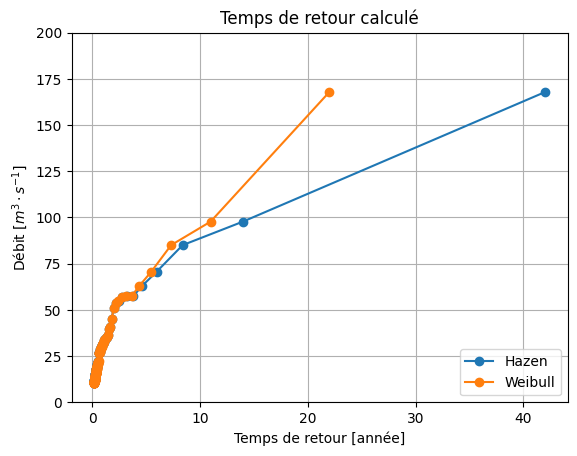

In [217]:
### SERIES TRONQUEES
reper = "seriesTronquees/"
serieTronquees = importDebitAnnuels(reper+"data_import.txt", "%d.%m.%Y")
plot_stationnarite(serieTronquees, reper+"serieTronquees")

serieTronquees = calcul_TempsRetour(serieTronquees, ["Weibull"], traitement = "tronquee")
plot_tempsRetour(serieTronquees, reper+"serieTronquees")
exportData(serieTronquees, reper+"exportTempsRetour.txt")
#TODO : faire le traitement Gumbel